### crnn 网络定义

#### backbone

In [3]:
%load_ext nb_black

import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBNLayer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        groups=1,
        is_vd_mode=False,
        act=None,
        name=None,
    ):
        super(ConvBNLayer, self).__init__()
        self.act = act
        self.is_vd_mode = is_vd_mode
        self._pool2d_avg = nn.AvgPool2d(
            kernel_size=stride, stride=stride, padding=0, ceil_mode=True
        )

        self._conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1 if is_vd_mode else stride,
            padding=(kernel_size - 1) // 2,
            groups=groups,
            bias=False,
        )

        self._batch_norm = nn.BatchNorm2d(
            out_channels,
        )
        if self.act == "relu":
            self._act = nn.ReLU(inplace=True)

    def forward(self, inputs):
        if self.is_vd_mode:
            inputs = self._pool2d_avg(inputs)
        y = self._conv(inputs)
        y = self._batch_norm(y)
        if self.act is not None:
            y = self._act(y)
        return y


class BottleneckBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        stride,
        shortcut=True,
        if_first=False,
        name=None,
    ):
        super(BottleneckBlock, self).__init__()

        self.conv0 = ConvBNLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            act="relu",
            name=name + "_branch2a",
        )
        self.conv1 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            act="relu",
            name=name + "_branch2b",
        )
        self.conv2 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels * 4,
            kernel_size=1,
            act=None,
            name=name + "_branch2c",
        )

        if not shortcut:
            self.short = ConvBNLayer(
                in_channels=in_channels,
                out_channels=out_channels * 4,
                kernel_size=1,
                stride=stride,
                is_vd_mode=not if_first and stride[0] != 1,
                name=name + "_branch1",
            )

        self.shortcut = shortcut

    def forward(self, inputs):
        y = self.conv0(inputs)

        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)
        y = short + conv2
        y = F.relu(y)
        return y


class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        stride,
        shortcut=True,
        if_first=False,
        name=None,
    ):
        super(BasicBlock, self).__init__()
        self.stride = stride
        self.conv0 = ConvBNLayer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            act="relu",
            name=name + "_branch2a",
        )
        self.conv1 = ConvBNLayer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            act=None,
            name=name + "_branch2b",
        )

        if not shortcut:
            self.short = ConvBNLayer(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=stride,
                is_vd_mode=not if_first and stride[0] != 1,
                name=name + "_branch1",
            )

        self.shortcut = shortcut

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)

        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)
        y = short + conv1
        y = F.relu(y)
        return y


class ResNet(nn.Module):
    def __init__(self, in_channels=3, layers=50, **kwargs):
        super(ResNet, self).__init__()

        self.layers = layers
        supported_layers = [18, 34, 50, 101, 152, 200]
        assert (
            layers in supported_layers
        ), "supported layers are {} but input layer is {}".format(
            supported_layers, layers
        )

        if layers == 18:
            depth = [2, 2, 2, 2]
        elif layers == 34 or layers == 50:
            depth = [3, 4, 6, 3]
        elif layers == 101:
            depth = [3, 4, 23, 3]
        elif layers == 152:
            depth = [3, 8, 36, 3]
        elif layers == 200:
            depth = [3, 12, 48, 3]
        num_channels = [64, 64, 128, 256]
        num_filters = [64, 128, 256, 512]

        self.conv1_1 = ConvBNLayer(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=3,
            stride=1,
            act="relu",
            name="conv1_1",
        )
        self.conv1_2 = ConvBNLayer(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            act="relu",
            name="conv1_2",
        )
        self.conv1_3 = ConvBNLayer(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            act="relu",
            name="conv1_3",
        )
        self.pool2d_max = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # self.block_list = list()
        self.block_list = nn.Sequential()
        if layers >= 50:
            for block in range(len(depth)):
                shortcut = False
                for i in range(depth[block]):
                    if layers in [101, 152, 200] and block == 2:
                        if i == 0:
                            conv_name = "res" + str(block + 2) + "a"
                        else:
                            conv_name = "res" + str(block + 2) + "b" + str(i)
                    else:
                        conv_name = "res" + str(block + 2) + chr(97 + i)

                    if i == 0 and block != 0:
                        stride = (2, 1)
                    else:
                        stride = (1, 1)

                    bottleneck_block = BottleneckBlock(
                        in_channels=num_channels[block]
                        if i == 0
                        else num_filters[block] * 4,
                        out_channels=num_filters[block],
                        stride=stride,
                        shortcut=shortcut,
                        if_first=block == i == 0,
                        name=conv_name,
                    )
                    shortcut = True
                    # self.block_list.append(bottleneck_block)
                    self.block_list.add_module(
                        "bb_%d_%d" % (block, i), bottleneck_block
                    )
                self.out_channels = num_filters[block]
        else:
            for block in range(len(depth)):
                shortcut = False
                for i in range(depth[block]):
                    conv_name = "res" + str(block + 2) + chr(97 + i)
                    if i == 0 and block != 0:
                        stride = (2, 1)
                    else:
                        stride = (1, 1)

                    basic_block = BasicBlock(
                        in_channels=num_channels[block]
                        if i == 0
                        else num_filters[block],
                        out_channels=num_filters[block],
                        stride=stride,
                        shortcut=shortcut,
                        if_first=block == i == 0,
                        name=conv_name,
                    )

                    shortcut = True
                    self.block_list.add_module("bb_%d_%d" % (block, i), basic_block)
                self.out_channels = num_filters[block]
        self.out_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, inputs):
        y = self.conv1_1(inputs)
        y = self.conv1_2(y)
        y = self.conv1_3(y)
        y = self.pool2d_max(y)
        for block in self.block_list:
            y = block(y)
        y = self.out_pool(y)

        return y

<IPython.core.display.Javascript object>

## neck-BiLSTM, head-CTC

In [4]:
%load_ext nb_black


class EncoderWithRNN(nn.Module):
    def __init__(self, in_channels, hidden_size):
        super(EncoderWithRNN, self).__init__()
        self.out_channels = hidden_size * 2
        self.lstm = nn.LSTM(
            in_channels, hidden_size, num_layers=2, batch_first=True, bidirectional=True
        )  # batch_first:=True

    def forward(self, x):
        x, _ = self.lstm(x)
        return x


class CTCHead(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels=6625,
        fc_decay=0.0004,
        mid_channels=None,
        **kwargs
    ):
        super(CTCHead, self).__init__()
        if mid_channels is None:
            self.fc = nn.Linear(
                in_channels,
                out_channels,
                bias=True,
            )
        else:
            self.fc1 = nn.Linear(
                in_channels,
                mid_channels,
                bias=True,
            )
            self.fc2 = nn.Linear(
                mid_channels,
                out_channels,
                bias=True,
            )

        self.out_channels = out_channels
        self.mid_channels = mid_channels

    def forward(self, x, labels=None):
        if self.mid_channels is None:
            predicts = self.fc(x)
        else:
            predicts = self.fc1(x)
            predicts = self.fc2(predicts)

        if not self.training:
            predicts = F.softmax(predicts, dim=2)
        return predicts


class PaddleOCRBiLSTM(nn.Module):
    def __init__(self, in_channels, hidden_size=48, **kwargs):
        super(PaddleOCRBiLSTM, self).__init__()
        self.backbone = ResNet(in_channels, layers=34)
        self.neck = EncoderWithRNN(self.backbone.out_channels, hidden_size)
        self.head = CTCHead(self.neck.out_channels)

    def forward(self, x):
        x = self.backbone(x)
        B, C, H, W = x.shape
        assert H == 1
        x = x.squeeze(dim=2)
        x = x.permute(0, 2, 1)
        x = self.neck(x)
        x = self.head(x)
        return x

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## dict and decode

In [12]:
alphabets_path = "./ppocr_keys_v1.txt"

with open(alphabets_path, "rb") as f:
    lines = f.readlines()

char_list = [char.decode("utf-8").strip("\n").strip("\r\n") for char in lines]
alphabets = ["blank"] + char_list + [" "]
# print(alphabets)
char_dict = {}
for i, char in enumerate(alphabets):
    char_dict[char] = i


def encode(text_list):
    length = [len(text) for text in text_list]
    max_length = max(length)
    labels = []
    for text in text_list:
        label = [char_dict[c] for c in text]
        label.extend([0] * (max_length - len(text)))
        labels.append(label)
    return torch.IntTensor(labels), torch.IntTensor(length)


def decode(preds, raw=True):
    print(preds)
    preds_prob, preds_idx = preds.max(axis=2)
    result_list = []
    for idx, prob in zip(preds_idx, preds_prob):
        if raw:
            result = [alphabets[int(index)] for index in idx]
            conf = prob
        else:
            result = []
            conf = []
            for i, index in enumerate(idx):
                if index != 0 and not ((i > 0) and (idx[i] == idx[i - 1])):
                    result.append(alphabets[int(idx[i])])
                    conf.append(float(prob[i]))
        result_list.append((result, conf))
    return result_list

<IPython.core.display.Javascript object>

## Model Convet

In [ ]:
import paddle


checkpoints = "./ch_ppocr_server_v2.0_rec_pre/best_accuracy"
para_dict = paddle.load(checkpoints + ".pdparams")
opti_dict = paddle.load(checkpoints + ".pdopt")

for k, v in para_dict.items():
    print(k, v.shape)
    
net = PaddleOCRBiLSTM(3, hidden_size=256)

def ppmodel2pytorch(net, para_dict)
    for k, v in net.state_dict().items():
        # print(k, v.shape)
        pk = k.replace("block_list.", "")
        if pk.endswith("running_mean"):
            pk = pk.replace("running_mean", "_mean")
        elif pk.endswith("running_var"):
            pk = pk.replace("running_var", "_variance")
        elif pk.startswith("neck"):
            pk = pk.replace("neck", "neck.encoder")
        elif pk.endswith("num_batches_tracked"):
            continue

        net.state_dict()[k].copy_(
            torch.from_numpy(
                para_dict[pk].numpy().T,
            )
            if pk.endswith("fc.weight")
            else torch.Tensor(para_dict[pk].numpy())
        )
        torch.save(
            net.state_dict(),
            "ch_ppocr_server_v2.0_rec_pre.pth",
            _use_new_zipfile_serialization=False,
        )


# a = net.state_dict()[
#     "backbone.block_list.bb_1_3.conv1._batch_norm.running_mean"
# ].numpy()
# b = para_dict["backbone.bb_1_3.conv1._batch_norm._mean"].numpy()
# assert a.all() == b.all()

眾 急 今 息 迎 鬼 及 搞 究 恐 餐 擔_988.jpg


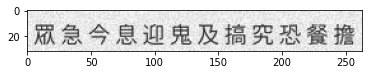

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['欢', '急', '今', '息', '迎', '鬼', '及', '搞', '究', '恐', '餐', '据'], [0.0002152018278138712, 0.0004048865521326661, 0.0003868818748742342, 0.00040846801130101085, 0.00040856917621567845, 0.00038766636862419546, 0.00040889807860367, 0.0004008352116215974, 0.0004063794040121138, 0.00040409763460047543, 0.00040416695992462337, 0.00017672739340923727])]
順 拜 分 陽 度 牛 錢 原 睡 封 裡 手_366.jpg


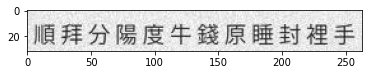

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['顺', '拜', '分', '阳', '度', '牛', '原', '睡', '封', '手'], [0.0003897370188497007, 0.00040057612932287157, 0.00040929237729869783, 0.00022967129189055413, 0.00040927453665062785, 0.0004071598523296416, 0.00040893585537560284, 0.00038426104583777487, 0.0004090233123861253, 0.0004093222669325769])]
究 陳 灣 筆 痛 嚴 類 若 付 督 聯 另_474.jpg


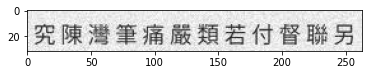

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['究', '陳', '湾', '笔', '痛', '若', '付', '督', '联', '另'], [0.0004009764816146344, 0.00021596282022073865, 0.00018423187430016696, 0.00021131447283551097, 0.0004088770947419107, 0.00040578757761977613, 0.00040269800228998065, 0.0004051548021379858, 0.0002720082411542535, 0.0004063907254021615])]
增 險 停 果 掉 哪 含 館 己 顯 聊 套_521.jpg


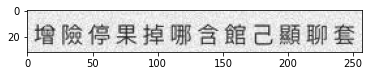

torch.Size([1, 64, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['增', '险', '停', '果', '掉', '哪', '含', '館', '己', '順', '聊', '套'], [0.0003871411026921123, 0.00039020771509967744, 0.00040930870454758406, 0.00040980358608067036, 0.00040428206557407975, 0.00038127985317260027, 0.0003953484701924026, 0.00028437093715183437, 0.0002635133278090507, 0.00016328626952599734, 0.0003918654110748321, 0.00040961045306175947])]
至 器 哇 附 黨 七 微 北 解 興 佛 恐_638.jpg


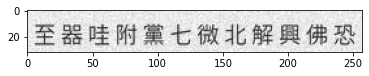

torch.Size([1, 64, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['至', '器', '哇', '附', '薰', '七', '微', '北', '解', '興', '佛', '恐'], [0.0004093438619747758, 0.0004074688476976007, 0.000381005578674376, 0.00040432345122098923, 0.0001729709329083562, 0.0004096631600987166, 0.00040945099317468703, 0.0004096782940905541, 0.00040922340122051537, 0.0002847349096555263, 0.00040867843199521303, 0.0004082057857885957])]
見 蘭 轉 料 破 ﻿的 稱 雖 推 父 花 急_647.jpg


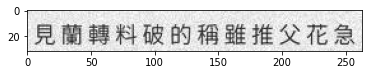

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['兒', '蘭', '转', '料', '破', '的', '稀', '雕', '推', '父', '花', '急'], [0.00017003095126710832, 0.0003848264750558883, 0.00025803514290601015, 0.00040740749682299793, 0.00040253574843518436, 0.00041012055589817464, 0.00016101187793537974, 0.00016856647562235594, 0.0004071058938279748, 0.0004029073170386255, 0.0004097181954421103, 0.00040578440530225635])]
片 字 突 派 道 版 際 檢 北 產 配 之_221.jpg


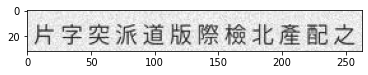

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['片', '字', '突', '派', '道', '版', '检', '北', '配', '之'], [0.0004091758164577186, 0.00040955469012260437, 0.000394717906601727, 0.00040952887502498925, 0.0004098651115782559, 0.00040892005199566483, 0.00026803341461345553, 0.00040997349424287677, 0.00040801058639772236, 0.00039855873910710216])]
剛 哇 斷 門 響 本 豬 館 客 血 部 錯_916.jpg


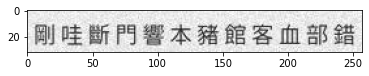

torch.Size([1, 64, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['刚', '哇', '断', '門', '本', '猪', '館', '客', '血', '部', '错'], [0.00028579053469002247, 0.00032877741614356637, 0.00037711928598582745, 0.00027800106909126043, 0.00040775761590339243, 0.0003175445890519768, 0.0003534683783072978, 0.000409509870223701, 0.00040860447916202247, 0.00040982451173476875, 0.0001987382274819538])]
萬 懂 逢 拜 輸 磁 努 成 笑 阿 紹 印_640.jpg


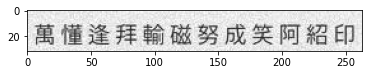

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['万', '懂', '逢', '拜', '翰', '磁', '努', '成', '笑', '阿', '绍', '印'], [0.000302299449685961, 0.0003960434696637094, 0.0003907796635758132, 0.00038318478618748486, 0.00032253042445518076, 0.000407945568440482, 0.000398778123781085, 0.00040933271520771086, 0.0004058911290485412, 0.0004056155448779464, 0.00028793944511562586, 0.00040995993185788393])]
司 改 些 絕 貴 午 念 鐘 急 城 物 網_99.jpg


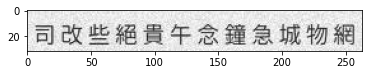

torch.Size([1, 66, 6625])
tensor([[[0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         ...,
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
         [0.0004, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]]])
[(['司', '改', '些', '绝', '贵', '午', '念', '急', '城', '物', '网'], [0.0004074244643561542, 0.0004091940354555845, 0.00040895023266784847, 0.00019787072960752994, 0.00023029457952361554, 0.0004069158749189228, 0.0003912562970072031, 0.0004089263384230435, 0.0004089468566235155, 0.0004098801000509411, 0.0002877619117498398])]


<IPython.core.display.Javascript object>

In [13]:
from pytorch_model_summary import summary
import numpy as np
import cv2, math
import torch.nn.functional as F
import matplotlib.pyplot as plt

# print(summary(net, torch.zeros((8, 3, 32, 280)), show_input=True, max_depth=4))
net = PaddleOCRBiLSTM(3, hidden_size=256)


def load(net, model_path="./ch_ppocr_server_v2.0_rec_pre.pth"):
    net.cuda()
    net.load_state_dict(
        torch.load(model_path, map_location=lambda storage, loc: storage.cuda(0))
    )
    net.eval()


load(net)


def predict(net, img):
    h, w = img.shape[:2]
    rh = 32
    rw = math.ceil(32 / h * w)
    img = cv2.resize(img, (rw, rh))
    img = img.astype("float32").transpose((2, 0, 1)) / 255
    img -= 0.5
    img /= 0.5
    inp = img[np.newaxis, :]
    inp = torch.from_numpy(inp).cuda()
    with torch.no_grad():
        preds = net(inp)
        print(preds.shape)
        preds = F.softmax(preds, dim=2)
    preds = preds.cpu()
    result_list = decode(preds, raw=False)
    return result_list


data_dir = "./patches/"
for n in os.listdir(data_dir)[:10]:
    print(n)
    img = cv2.imread(data_dir + n)
    plt.imshow(img[:, :, ::-1])
    plt.show()
    result_list = predict(net, img)
    print(result_list)